# Bagging alogorithm (using KNN as base estimator)

- performs best with algorithms that have __high variance.__

- fits base classifiers random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. 

- Such a meta-estimator can typically be used as a way to reduce the variance of a __black-box estimator __ (e.g., a decision tree)

- How 
> by introducing randomization into its construction procedure and then making an ensemble out of it.



### parameters 

__base_estimator : __ 
The base estimator to fit on random subsets of the dataset. 
If None, then the base estimator is a decision tree.

__n_estimators :  int, optional (default=10)__
The number of base estimators in the ensemble.

__max_samples : int or float, optional (default=1.0)__
If int, then draw max_samples samples.
If float, then draw max_samples * X.shape[0] samples.
                
__max_features : int or float, optional (default=1.0) __
The number of features to draw from X to train each base estimator.
If int, then draw max_features features.
If float, then draw max_features * X.shape[1] features.
                
__bootstrap : boolean, optional (default=True)__
Whether samples are drawn with replacement.

__bootstrap_features : boolean, optional (default=False)__
Whether features are drawn with replacement.

__oob_score : bool, optional (default=False)__
Whether to use out-of-bag samples to estimate the generalization error.


In [1]:
# Bagged Decision Trees for Classification
import pandas as pd
import numpy as np
from sklearn import model_selection

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut 

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import adjusted_rand_score

### parameters 

__base_estimator : __ 
The base estimator to fit on random subsets of the dataset. 
If None, then the base estimator is a decision tree.

__n_estimators :  int, optional (default=10)__
The number of base estimators in the ensemble.

__max_samples : int or float, optional (default=1.0)__
If int, then draw max_samples samples.
If float, then draw max_samples * X.shape[0] samples.
                
__max_features : int or float, optional (default=1.0) __
The number of features to draw from X to train each base estimator.
If int, then draw max_features features.
If float, then draw max_features * X.shape[1] features.
                
__bootstrap : boolean, optional (default=True)__
Whether samples are drawn with replacement.

__bootstrap_features : boolean, optional (default=False)__
Whether features are drawn with replacement.

__oob_score : bool, optional (default=False)__
Whether to use out-of-bag samples to estimate the generalization error.


In [2]:
# pip install pydataset
from pydataset import data

In [3]:
# Get the housing data
df = data('Housing')
df.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [4]:
# Create dictionary to label 'yes' and 'no'
d = dict(zip(['no', 'yes'], range(0,2)))

for i in zip(df.dtypes.index, df.dtypes):
    if str(i[1]) == 'object':
        df[i[0]] = df[i[0]].map(d)

#### Pandas qcut

In [5]:
pd.qcut(range(1, 10, 1), 2)

[(0.999, 5.0], (0.999, 5.0], (0.999, 5.0], (0.999, 5.0], (0.999, 5.0], (5.0, 9.0], (5.0, 9.0], (5.0, 9.0], (5.0, 9.0]]
Categories (2, interval[float64]): [(0.999, 5.0] < (5.0, 9.0]]

In [6]:
pd.qcut(range(1, 10, 1), 3, labels=["good", "medium", "bad"])

[good, good, good, medium, medium, medium, bad, bad, bad]
Categories (3, object): [good < medium < bad]

.. back to the main code ..

In [8]:
# Before we bucket our prices, let’s look at the ranges of our prices.

# Looks like the lowest house we have in the dataset is $25K, and 
# the highest is $190K. 
for i, j in enumerate(np.unique(pd.qcut(df['price'], 3))):
    print(i, j)

0 (24999.999, 53000.0]
1 (53000.0, 74500.0]
2 (74500.0, 190000.0]


In [9]:
df['price'] = pd.qcut(df['price'], 3, labels=['0', '1', '2']).cat.codes

# Split into two sets
X = df.drop('price', 1)
y = df['price'] 

In [10]:
df.shape

(546, 12)

In [11]:
df.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,0,5850,3,1,2,1,0,1,0,0,1,0
2,0,4000,2,1,1,1,0,0,0,0,0,0
3,0,3060,3,1,1,1,0,0,0,0,0,0
4,1,6650,3,1,2,1,1,0,0,0,0,0
5,1,6360,2,1,1,1,0,0,0,0,0,0


In [42]:
# For testing, we choose to split our data to 75% train and 25% for test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [12]:
# instantiate a knn
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [13]:
# instantiate the bagging classifier
seed = 7

num_trees = 100

baggclf = BaggingClassifier(base_estimator=knn, 
                          n_estimators=num_trees, 
                          oob_score=True, 
                          max_samples=0.5, 
                          max_features=0.5,
                          random_state=seed)

In [45]:
# results = cross_val_score(baggclf, X, y, cv=kfold)

# print(results)
# print(results.mean())

In [14]:
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

scores = cross_validate(baggclf, 
                        X, 
                        y, 
                        cv=5, 
                        scoring=scoring, 
                        return_train_score=True 
                        #return_estimator=True
                       )

#print(scores.keys())
print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))


  Training accuracy :  [0.94266055 0.94508009 0.94508009 0.93135011 0.93363844]  mean :  0.94
  testing  accuracy :  [0.53636364 0.60550459 0.71559633 0.58715596 0.55963303]  mean :  0.6


In [14]:
for key in scores:
    print(key, scores[key], scores[key].mean() )

fit_time [0.32481384 0.24485016 0.29082084 0.2558434  0.25184584] 0.2736348152160645
score_time [0.37477064 0.37376881 0.38176489 0.36077714 0.3787694 ] 0.37397017478942873
test_accuracy [0.53636364 0.60550459 0.71559633 0.58715596 0.55963303] 0.6008507089241035
train_accuracy [0.94266055 0.94508009 0.94508009 0.93135011 0.93363844] 0.939561858375496
test_f1_macro [0.53429027 0.60167932 0.68466011 0.56967745 0.52199916] 0.5824612612785341
train_f1_macro [0.94234335 0.9450406  0.94505201 0.93077682 0.93359119] 0.9393607958572618
test_precision_macro [0.53888889 0.6325477  0.7244898  0.56636364 0.5292581 ] 0.5983096237217748
train_precision_macro [0.9426531  0.94617791 0.94639896 0.93342642 0.93468303] 0.9406678851901491
test_recall_macro [0.53362573 0.60385385 0.71396396 0.58658659 0.56031031] 0.5996680891417733
train_recall_macro [0.94263013 0.94491051 0.94491051 0.93094395 0.9334918 ] 0.9393773807364412


A case of __overfitted__ model, can we try a few other base models

In [15]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=4000, random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier()

In [16]:
labels  = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    print('Estimator : ', label)
    
    # scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    # print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    seed = 7

    num_trees = 100

    baggclf = BaggingClassifier(base_estimator=clf, 
                                n_estimators=num_trees, 
                                oob_score=True, 
                                max_samples=0.5, 
                                max_features='log2',
                                random_state=seed)
    
    scores = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=True, return_estimator=True)
    
    #print(scores.keys())
    print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
    print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

Estimator :  Logistic Regression
  Training accuracy :  [0.71330275 0.69336384 0.67734554 0.6979405  0.69336384]  mean :  0.7
  testing  accuracy :  [0.59090909 0.53211009 0.78899083 0.66055046 0.55963303]  mean :  0.63
Estimator :  Random Forest
  Training accuracy :  [0.99311927 0.99542334 0.99771167 0.99542334 0.99313501]  mean :  0.99
  testing  accuracy :  [0.56363636 0.55963303 0.70642202 0.75229358 0.62385321]  mean :  0.64
Estimator :  Naive Bayes
  Training accuracy :  [0.69495413 0.72997712 0.69565217 0.70022883 0.70022883]  mean :  0.7
  testing  accuracy :  [0.6        0.58715596 0.66972477 0.67889908 0.57798165]  mean :  0.62
Estimator :  Decision Tree
  Training accuracy :  [0.99311927 0.99542334 0.99771167 0.99542334 0.99542334]  mean :  1.0
  testing  accuracy :  [0.49090909 0.55963303 0.59633028 0.69724771 0.57798165]  mean :  0.58


Both RF and DT show similar case of overfitting and LogReg and NB show the case of underfitted model

#### Can we try scaling the data ?

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [17]:
rescaledX = scaler.fit_transform(X)


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [19]:
labels  = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    print('Estimator : ', label)
    
    # scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    # print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    seed = 7

    num_trees = 100

    baggclf = BaggingClassifier(base_estimator=clf, 
                              n_estimators=num_trees, 
                              oob_score=True, 
                              max_samples=0.5, 
                              max_features=0.5,
                              random_state=seed)
    
    scores = cross_validate(baggclf, rescaledX, y, cv=5, scoring=scoring, return_train_score=True, return_estimator=True)
    
    #print(scores.keys())
    print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
    print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

Estimator :  Logistic Regression
  Training accuracy :  [0.69495413 0.70938215 0.67963387 0.67963387 0.66361556]  mean :  0.69
  testing  accuracy :  [0.63636364 0.55963303 0.67889908 0.66972477 0.60550459]  mean :  0.63
Estimator :  Random Forest
  Training accuracy :  [0.88990826 0.89702517 0.89244851 0.87414188 0.87643021]  mean :  0.89
  testing  accuracy :  [0.58181818 0.60550459 0.76146789 0.69724771 0.69724771]  mean :  0.67
Estimator :  Naive Bayes
  Training accuracy :  [0.43119266 0.6979405  0.6201373  0.68421053 0.597254  ]  mean :  0.61
  testing  accuracy :  [0.41818182 0.55045872 0.67889908 0.66055046 0.48623853]  mean :  0.56
Estimator :  Decision Tree
  Training accuracy :  [0.93577982 0.9382151  0.94508009 0.9382151  0.91990847]  mean :  0.94
  testing  accuracy :  [0.58181818 0.6146789  0.75229358 0.69724771 0.67889908]  mean :  0.66


#### Try the following:-
- bootstrap=True          --> for the samples to be drawn with replacement
- bootstrap_features=True --> for the features to be drawn with replacement
- max_features={try 'sqrt', 'log2'}


In [20]:
labels  = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree']
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):
    print('Estimator : ', label)
    
    # scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    # print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    seed = 7

    num_trees = 100

    baggclf = BaggingClassifier(base_estimator=clf, 
                                n_estimators=num_trees, 
                                bootstrap=True, 
                                bootstrap_features=True,
                                oob_score=True, 
                                #max_samples=0.5, 
                                max_features='log2',
                                random_state=seed)
    
    scores = cross_validate(clf, rescaledX, y, cv=5, scoring=scoring, return_train_score=True, return_estimator=True)
    
    #print(scores.keys())
    print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
    print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

Estimator :  Logistic Regression
  Training accuracy :  [0.70412844 0.73913043 0.66361556 0.70251716 0.6979405 ]  mean :  0.7
  testing  accuracy :  [0.61818182 0.56880734 0.72477064 0.66055046 0.62385321]  mean :  0.64
Estimator :  Random Forest
  Training accuracy :  [0.99311927 0.99542334 0.99771167 0.99542334 0.99313501]  mean :  0.99
  testing  accuracy :  [0.56363636 0.55045872 0.70642202 0.75229358 0.62385321]  mean :  0.64
Estimator :  Naive Bayes
  Training accuracy :  [0.4587156  0.72768879 0.68421053 0.68878719 0.6201373 ]  mean :  0.64
  testing  accuracy :  [0.47272727 0.57798165 0.68807339 0.66055046 0.52293578]  mean :  0.58
Estimator :  Decision Tree
  Training accuracy :  [0.99311927 0.99542334 0.99771167 0.99542334 0.99542334]  mean :  1.0
  testing  accuracy :  [0.5        0.55963303 0.56880734 0.67889908 0.55963303]  mean :  0.57


#### look at the OOB score

In [21]:
rf = RandomForestClassifier(n_estimators=50, random_state=1)

baggclf = BaggingClassifier(base_estimator=rf, 
                            n_estimators=num_trees, 
                            bootstrap=True, 
                            bootstrap_features=True,
                            oob_score=True, 
                            #max_samples=0.5, 
                            max_features=0.5,
                            random_state=seed)

baggclf.fit(rescaledX, y)

# compare OOB accuracy to test-set accuracy
acc_oob = baggclf.oob_score_
print(acc_oob)                  

# clf4 = DecisionTreeClassifier()

0.6538461538461539


OOB score also indicates there is overfitting

In [22]:
dt = DecisionTreeClassifier(random_state=1)

baggclf = BaggingClassifier(base_estimator=dt, 
                            n_estimators=num_trees, 
                            bootstrap=True, 
                            bootstrap_features=True,
                            oob_score=True, 
                            #max_samples=0.5, 
                            max_features=0.5,
                            random_state=seed)

baggclf.fit(rescaledX, y)

# compare OOB accuracy to test-set accuracy
acc_oob = baggclf.oob_score_
print(acc_oob)               

0.673992673992674


OOB score also indicates there is overfitting, still , with decision tree too!!!

# Getting feature importances

In [23]:
dt = DecisionTreeClassifier(random_state=1)

baggclf = BaggingClassifier(base_estimator=dt, 
                            n_estimators=num_trees, 
                            bootstrap=True, 
                            bootstrap_features=True,
                            oob_score=True, 
                            #max_samples=0.5, 
                            #max_features=0.5,
                            random_state=seed)

baggclf.fit(rescaledX, y)

feature_importances = np.mean([ tree.feature_importances_ for tree in baggclf.estimators_ ], axis=0)
feature_importances

array([0.08052217, 0.08952341, 0.10497491, 0.10511788, 0.07184493,
       0.07978365, 0.09757261, 0.08620304, 0.08672396, 0.08933314,
       0.10840031])

In [24]:
X.columns

Index(['lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway', 'recroom',
       'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea'],
      dtype='object')

In [25]:
# feature Importance
# Get numerical feature importances
importances = list(feature_importances)
importances

[0.08052217471673419,
 0.0895234075615725,
 0.1049749133448776,
 0.10511787794100907,
 0.07184492571332271,
 0.07978364694326485,
 0.09757260570015848,
 0.08620303893143744,
 0.08672396436641894,
 0.0893331351101615,
 0.10840030967104264]

In [26]:
# List of tuples with feature and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
feature_importances

[('lotsize', 0.08),
 ('bedrooms', 0.09),
 ('bathrms', 0.1),
 ('stories', 0.11),
 ('driveway', 0.07),
 ('recroom', 0.08),
 ('fullbase', 0.1),
 ('gashw', 0.09),
 ('airco', 0.09),
 ('garagepl', 0.09),
 ('prefarea', 0.11)]

In [27]:
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

[('stories', 0.11),
 ('prefarea', 0.11),
 ('bathrms', 0.1),
 ('fullbase', 0.1),
 ('bedrooms', 0.09),
 ('gashw', 0.09),
 ('airco', 0.09),
 ('garagepl', 0.09),
 ('lotsize', 0.08),
 ('recroom', 0.08),
 ('driveway', 0.07)]

# check if multi collinearity exists

In [28]:
import scipy 
import scipy.linalg as la

In [29]:
# check the multi collinearity
corr = scipy.corrcoef(rescaledX, rowvar=False)

eigvals, eigvecs = la.eig(corr)

eigvals = eigvals.real

print(eigvals)
print(eigvecs)

[2.3461189  1.52999098 1.27587979 1.12821178 0.41448624 0.88881525
 0.57351177 0.65105512 0.62668567 0.82660122 0.73864329]
[[ 3.92164874e-01  1.59180688e-01  3.68968167e-01 -1.00700384e-01
  -2.62098429e-01  1.64572662e-01  4.39704949e-01 -6.10146807e-01
   8.25598657e-02 -7.50598365e-02  2.72161271e-02]
 [ 3.66846345e-01 -3.30684879e-01 -2.93715887e-01 -8.71768181e-02
   4.14460236e-01 -1.07853186e-02  3.09442210e-01  1.30284258e-01
   4.96711475e-01 -3.33313318e-01 -1.40571382e-01]
 [ 3.85501137e-01 -2.51365191e-01 -2.37495389e-01 -1.64831836e-01
   1.19938521e-01  1.23792635e-01 -1.40058738e-01 -1.50181164e-01
  -7.45150026e-01 -1.22559935e-01 -2.49961246e-01]
 [ 3.32323080e-01 -4.86771906e-01 -5.74109660e-02  1.83413163e-01
  -6.25766086e-01 -3.46932918e-01 -2.24517242e-01  3.88599357e-02
   1.69993100e-01  1.50673734e-01 -1.46326859e-02]
 [ 2.60635411e-01  2.09911810e-01  4.42992120e-01  4.69076682e-03
   2.07198291e-01 -4.77761656e-01  1.62354240e-01  3.20642010e-01
  -1.0970314

there seems to __no multi-collinearity__, as there no eigen value = 0

In [30]:
new_X = pd.DataFrame(data=rescaledX, columns=X.columns)

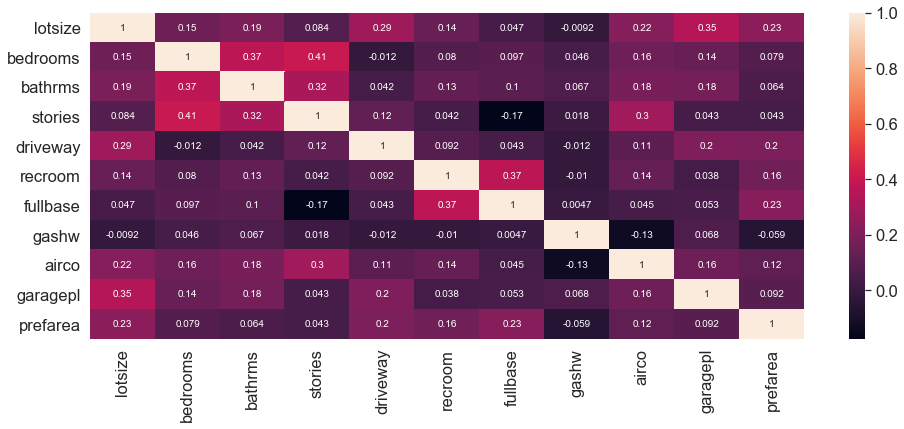

In [31]:
plt.figure(figsize=(16, 6))
sns.heatmap(new_X.corr(), annot=True);

no strong correlation between the independent variables, as well.



# let us check VIF for multi-collinearity

VIF values of 10 or greater indicate __Multicolinearity__

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy as sp

In [33]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["feature"] = X.columns

vif.sort_values(['VIF_Factor'], ascending=False).round(5)

,VIF_Factor,feature
1,15.21354,bedrooms
2,9.39300,bathrms
0,8.24919,lotsize
3,7.89420,stories
4,6.77910,driveway
6,2.01263,fullbase
9,1.94178,garagepl
8,1.74445,airco
10,1.48497,prefarea
5,1.46563,recroom


** observation **

there is some indication of multi-collinearity with columns
- bedrooms
- bathrms

But not too bad, it appears

# But why the overfitting???

In [34]:
new_X.head()

,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,0.288660,0.4,0.0,0.333333,1.0,0.0,1.0,0.0,0.0,0.333333,0.0
1,0.161512,0.2,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.096907,0.4,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.343643,0.4,0.0,0.333333,1.0,1.0,0.0,0.0,0.0,0.000000,0.0
4,0.323711,0.2,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0


# let us try learning curve

In [35]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=4000, random_state=1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier()

In [36]:
# instantiate the bagging classifier
num_trees = 10

baggclf = BaggingClassifier(base_estimator=clf2, 
                          n_estimators=num_trees, 
                          random_state=1)

In [37]:
scoring = ['accuracy']

scores = cross_validate(baggclf, 
                        rescaledX, 
                        y, 
                        cv=5, 
                        scoring=scoring, 
                        return_train_score=True
                        )

#print(scores.keys())
print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

  Training accuracy :  [0.96330275 0.96796339 0.97254005 0.9610984  0.95881007]  mean :  0.96
  testing  accuracy :  [0.59090909 0.60550459 0.76146789 0.74311927 0.65137615]  mean :  0.67


In [38]:
# execute the learning curve
train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator=baggclf,
                                                         X=rescaledX,
                                                         y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         cv=10
                                                         )

In [40]:
train_sizes

array([ 49,  98, 147, 196, 245, 294, 343, 392, 441, 491])

In [42]:
test_scores

array([[0.4       , 0.65454545, 0.47272727, 0.52727273, 0.65454545,
        0.72727273, 0.53703704, 0.48148148, 0.64814815, 0.51851852],
       [0.49090909, 0.67272727, 0.49090909, 0.54545455, 0.58181818,
        0.6       , 0.42592593, 0.44444444, 0.57407407, 0.61111111],
       [0.50909091, 0.65454545, 0.54545455, 0.54545455, 0.63636364,
        0.67272727, 0.57407407, 0.53703704, 0.62962963, 0.66666667],
       [0.49090909, 0.63636364, 0.49090909, 0.52727273, 0.65454545,
        0.67272727, 0.62962963, 0.51851852, 0.61111111, 0.64814815],
       [0.45454545, 0.58181818, 0.50909091, 0.56363636, 0.65454545,
        0.69090909, 0.61111111, 0.51851852, 0.62962963, 0.64814815],
       [0.50909091, 0.67272727, 0.52727273, 0.52727273, 0.70909091,
        0.63636364, 0.53703704, 0.53703704, 0.62962963, 0.64814815],
       [0.47272727, 0.63636364, 0.56363636, 0.54545455, 0.67272727,
        0.69090909, 0.81481481, 0.66666667, 0.68518519, 0.61111111],
       [0.49090909, 0.65454545, 0.5636363

In [43]:
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores,  axis=1)

test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores,  axis=1)

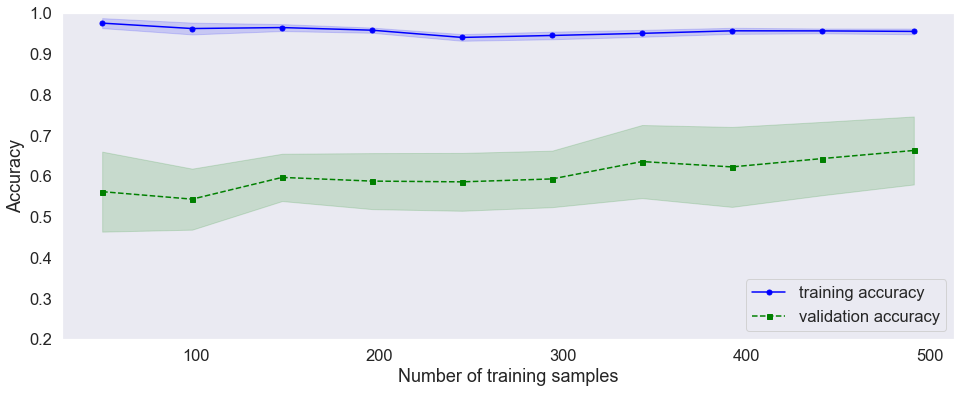

In [44]:
plt.figure(figsize=(16, 6))

plt.plot(train_sizes, 
         train_mean,
         color='blue', 
         marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
         train_mean + train_std,
         train_mean - train_std,
         alpha=0.15, 
         color='blue')  

plt.plot(train_sizes, 
         test_mean,
         color='green', 
         linestyle='--',
         marker='s', 
         markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, 
                 color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.2, 1.0]);

# Still not improved, Increase sample size, may be!

# PCA

In [165]:
from itertools import combinations
from itertools import combinations_with_replacement 
from itertools import permutations 

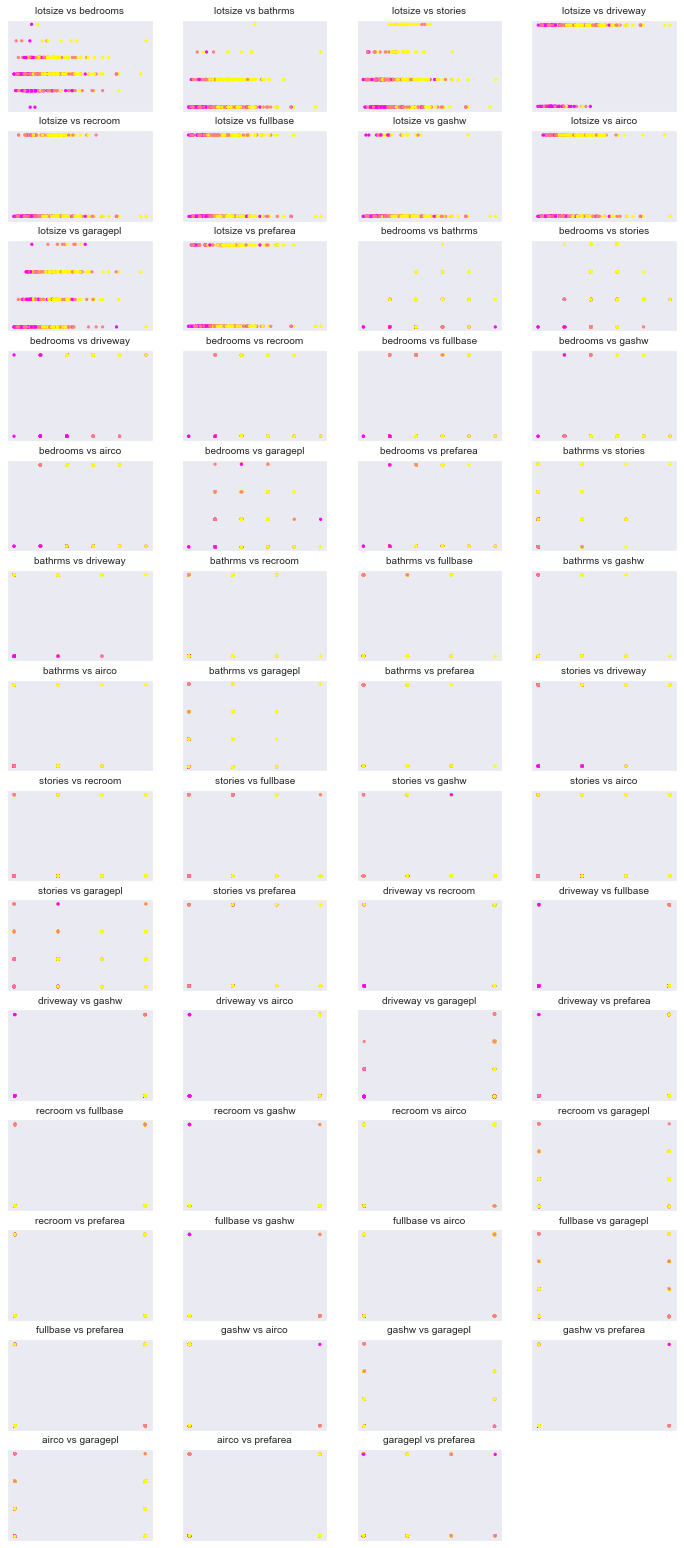

In [166]:
plt.figure(figsize=(12,30))

i = 1
for col_c in list(combinations(X.columns, 2)):
    
    col1 = col_c[0]
    col2 = col_c[1]
    
    plt.subplot(15, 4, i)
    plt.title(col1+' vs '+col2, fontsize=10)
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(X[col1], 
                X[col2],
                c=y,
                cmap='spring',
                s=5
    );
    i = i +1

In [167]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

In [168]:
pc = pca.fit_transform(rescaledX)

In [169]:
# make a pandas data frame with the principal components (PCs) and 
# the known cluster assignments.

pc_df = pd.DataFrame(data = pc , 
                     columns = ['PC1', 'PC2','PC3','PC4'])

pc_df['Cluster'] = y

print(pc_df.shape)

print("Explained Variance: ", pca.explained_variance_ratio_)

(546, 5)
Explained Variance:  [0.26594813 0.19949716 0.13727251 0.09902298]


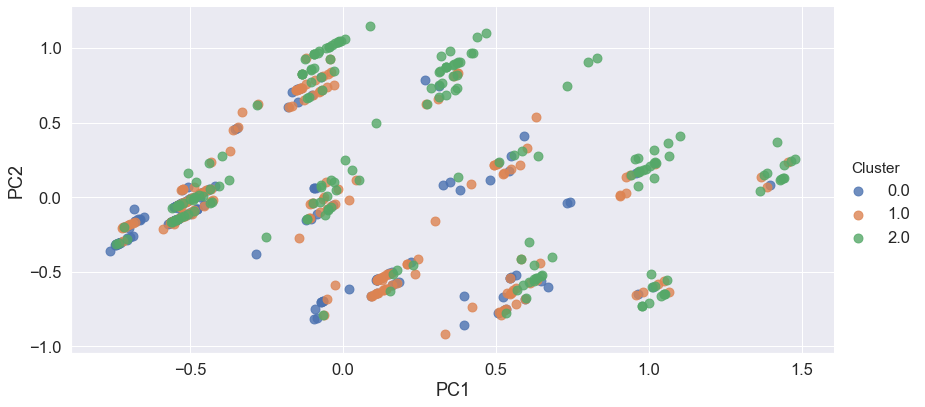

In [170]:
sns.lmplot(x="PC1", 
           y="PC2",
           data=pc_df, 
           fit_reg=False, 
           hue='Cluster', # color by cluster
           legend=True,
           scatter_kws={"s": 80},
           height=6,
           aspect=2);

<IPython.core.display.Javascript object>


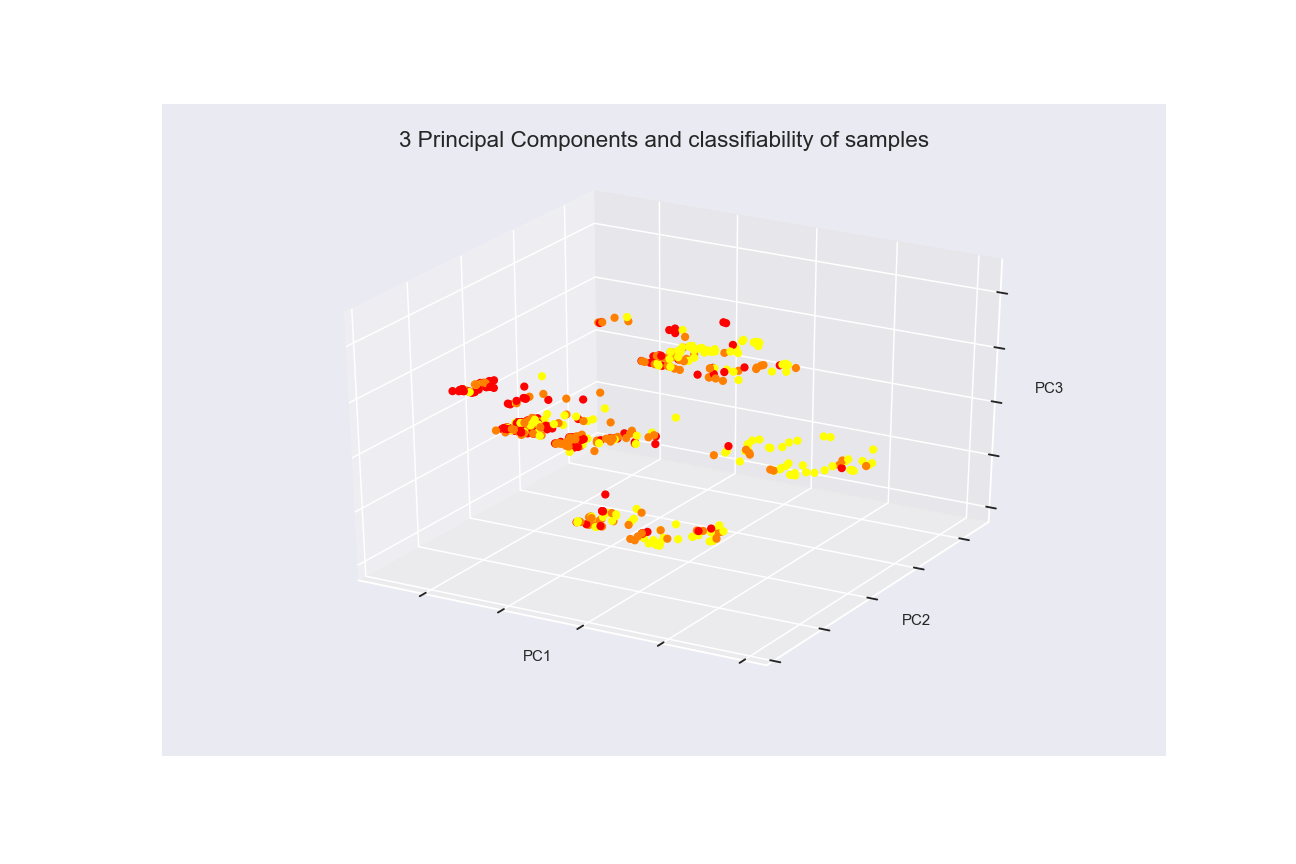

In [171]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter( pc_df['PC1'],
            pc_df['PC2'],
            pc_df['PC3'],
            c=pc_df['Cluster'], 
            marker='o', 
            alpha=1,
            cmap='autumn')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_zlabel('PC3', fontsize=10)

ax.set_title('3 Principal Components and classifiability of samples', fontsize=15)

ax.dist = 12

# Using Adaboost classifier

In [190]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [192]:
# Create and fit an AdaBoosted decision tree
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=300)

bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [193]:
scoring = ['accuracy']

scores = cross_validate(adb, 
                        rescaledX, 
                        y, 
                        cv=5, 
                        scoring=scoring, 
                        return_train_score=True
                        )

#print(scores.keys())
print('  Training accuracy : ', scores['train_accuracy'], ' mean : ', round(scores['train_accuracy'].mean(), 2))
print('  testing  accuracy : ', scores['test_accuracy'] , ' mean : ', round(scores['test_accuracy'].mean(),2 ))

  Training accuracy :  [0.75917431 0.75057208 0.71395881 0.70251716 0.71853547]  mean :  0.73
  testing  accuracy :  [0.58181818 0.53211009 0.66055046 0.68807339 0.65137615]  mean :  0.62
